In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,BatchNormalization,Dense,GlobalAveragePooling2D
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [2]:
train_data =  'C:\\Users\\Donia\\Desktop\\Train\\Train'
print(os.listdir(train_data))

['Fire', 'NoFire']


In [3]:
train_fire = os.listdir(os.path.join(train_data,'FIRE'))
train_not_fire = os.listdir(os.path.join(train_data,'NOFIRE'))

In [4]:
fig_index=0

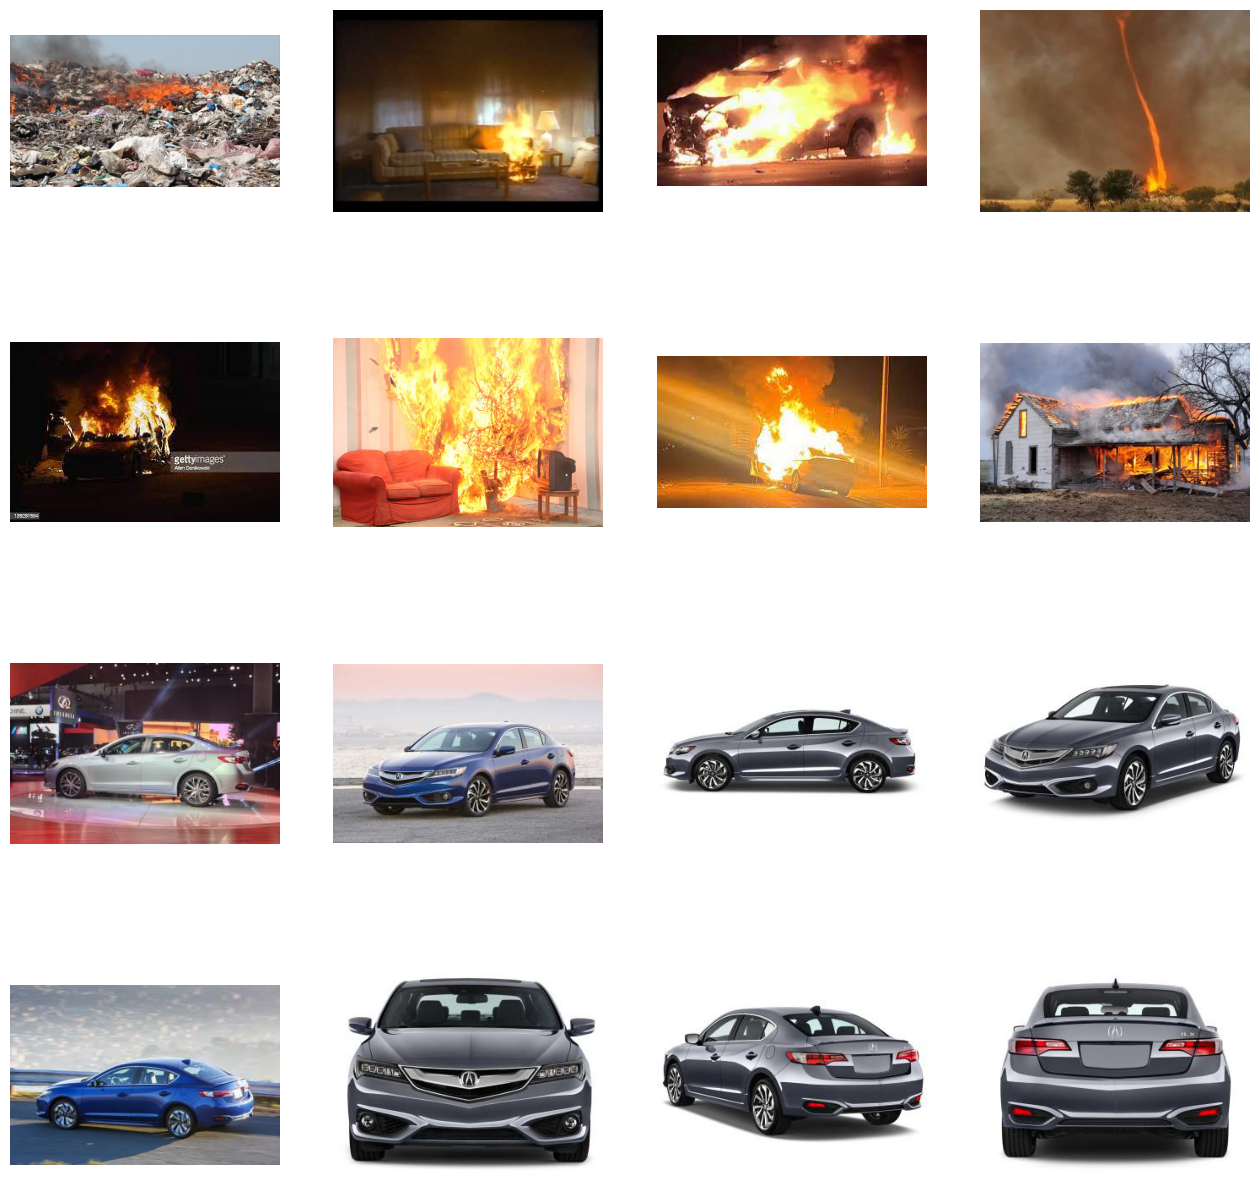

In [5]:

# Setting number of columns and number of rows to view sample images
n_rows = 4
n_cols = 4
# Here we are using gcf to clen the plot if the cell is being runned 2 or more times
fig = plt.gcf()

# Setting the size of each image
fig.set_size_inches(n_rows*4,n_cols*4)

fig_index+=8

# Pulling 8 images from each class to display
fire_8 = [os.path.join(train_data,'FIRE',fname) for fname in train_fire[fig_index-8:fig_index]]
not_fire_8 = [os.path.join(train_data,'NOFIRE',fname) for fname in train_not_fire[fig_index-8:fig_index]]

# Printing the images from each class, if you notice you will see first 8 images will have fire in them other 8 will not have fire in them
for i,img_path in enumerate(fire_8+not_fire_8):
    sp = plt.subplot(n_rows,n_cols,i+1)
    sp.axis('Off')
    img = mimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [6]:
# Using tensorflow's ImageDataGenerator to prepare the image-data for training
train_gen = ImageDataGenerator(width_shift_range = 0.5,
                              height_shift_range = 0.5,
                              validation_split = 0.3)

train_set = train_gen.flow_from_directory(train_data,target_size = (300,300),class_mode = 'binary',subset = 'training',batch_size = 32)

validation_set = train_gen.flow_from_directory(train_data,target_size = (300,300),class_mode = 'binary',subset = 'validation',batch_size = 32)

Found 8982 images belonging to 2 classes.
Found 3848 images belonging to 2 classes.


In [7]:
pre_trained_resnet_50 =keras.applications.ResNet152V2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
x = 0
for layer in pre_trained_resnet_50.layers:
    layer.trainable = False
    x+=1
    if x == 39:
        break

In [8]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Model

In [9]:
base_model = ResNet152V2(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer for binary classification
x = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, None, None, 64)       0         ['conv1_conv[0][0]']          
                                                                                              

In [13]:
callbacks = [EarlyStopping(monitor = 'val_loss',patience = 10,restore_best_weights=True)]
model_hist = model.fit(train_set,validation_data = validation_set,epochs = 15,callbacks = [callbacks])

Epoch 1/15
281/281 [==============================] - 10617s 38s/step - loss: 0.4117 - accuracy: 0.7817 - val_loss: 2.3483 - val_accuracy: 0.7664
Epoch 2/15
281/281 [==============================] - 10667s 38s/step - loss: 0.3497 - accuracy: 0.8033 - val_loss: 0.3799 - val_accuracy: 0.8532
Epoch 3/15
281/281 [==============================] - 10446s 37s/step - loss: 0.3323 - accuracy: 0.8337 - val_loss: 2.2133 - val_accuracy: 0.7892
Epoch 4/15
281/281 [==============================] - 10277s 37s/step - loss: 0.3251 - accuracy: 0.8328 - val_loss: 0.2996 - val_accuracy: 0.8701
Epoch 5/15
281/281 [==============================] - 10247s 36s/step - loss: 0.3152 - accuracy: 0.8396 - val_loss: 0.6066 - val_accuracy: 0.6198
Epoch 6/15
281/281 [==============================] - 10281s 37s/step - loss: 0.3149 - accuracy: 0.8380 - val_loss: 0.2808 - val_accuracy: 0.8771
Epoch 7/15
281/281 [==============================] - 11659s 42s/step - loss: 0.3077 - accuracy: 0.8435 - val_loss: 0.2381 -

In [16]:
loss, accuracy = model.evaluate(validation_set)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

121/121 [==============================] - 824s 7s/step - loss: 0.2764 - accuracy: 0.8550
Test loss: 0.27637386322021484
Test accuracy: 0.8549895882606506


In [15]:
result = model.evaluate(validation_set)
print('test Loss:', result[0])
print('test Accuracy:', result[1])

121/121 [==============================] - 815s 7s/step - loss: 0.2712 - accuracy: 0.8654
test Loss: 0.27119332551956177
test Accuracy: 0.8653846383094788


In [18]:
hist_=pd.DataFrame(model_hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.411731,0.781674,2.348333,0.766372
1,0.349741,0.803273,0.379901,0.853170
2,0.332307,0.833667,2.213288,0.789241
3,0.325126,0.832777,0.299626,0.870062
4,0.315165,0.839568,0.606574,0.619802
5,0.314926,0.838009,0.280779,0.877079
6,0.307671,0.843465,0.238083,0.901507
7,0.306077,0.847139,0.240304,0.882536
8,0.302597,0.846137,0.258982,0.898908
9,0.296700,0.854153,0.233670,0.894751


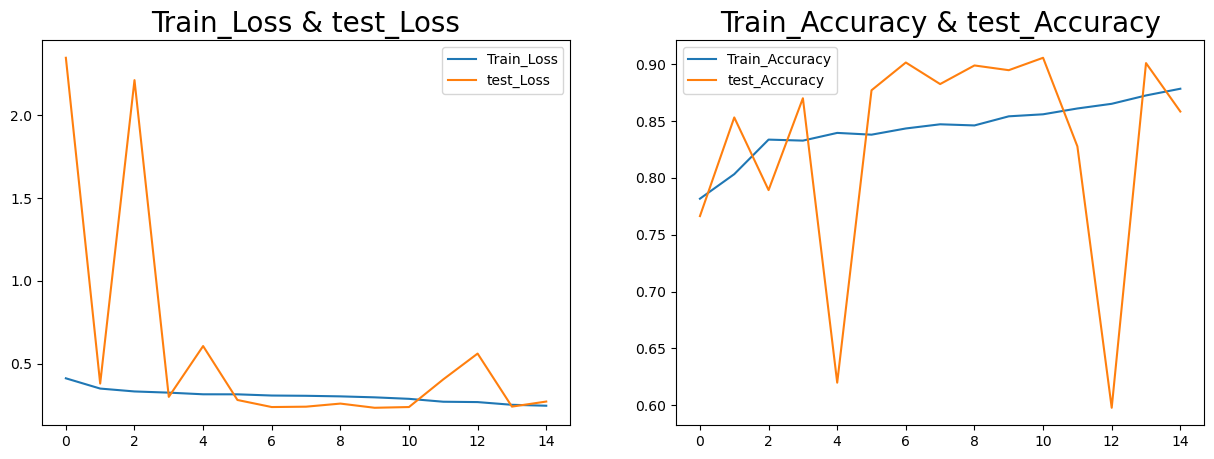

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='test_Loss')
plt.title('Train_Loss & test_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='test_Accuracy')
plt.title('Train_Accuracy & test_Accuracy',fontsize=20)
plt.legend()

In [20]:
# Downloading our best model that was picked up by Model-Checkpoint
best_model = tf.keras.models.load_model('/kaggle/working/final_model.h5')

# now checking the final evalutaion of our model
best_model.evaluate(validation_set)

121/121 [==============================] - 395s 3s/step - loss: 0.8521 - accuracy: 0.2336


[0.8520840406417847, 0.23362785577774048]

In [21]:
# Funtion to read image and transform image to tensor 
def load_and_prep_image(filename, img_shape = 300):
    img = tf.io.read_file(filename) #read image
    img = tf.image.decode_image(img) # decode the image to a tensor
    img = tf.image.resize(img, size = [img_shape, img_shape]) # resize the image
    return img